In [54]:
import numpy as np
import torch
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions as dist
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython import display
from time import sleep
import pandas as pd
import seaborn as sns

from inference.plot import plot_loss, plot_posterior
from simulate.simulate import simulate
from inference.plannar import NormalizingFlow

In [55]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [120]:
def plot_posterior(theta_flow, batch_size=1000, truth=None,
                   name=""):

    z0_θ = theta_flow.sample_base_dist(batch_size)
    zk_θ, prior_logprob_θ, log_det_θ = theta_flow(z0_θ)

    mu1, log_var_u1, log_var_w1 = zk_θ.data[:, :3].T
    mu2, log_var_u2, log_var_w2 = zk_θ.data[:, 3:].T

    fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

    alpha = 0.1

    ax = axes[0, 0]
    ax.set_title(r"$\alpha$ - $U$")
    ax.scatter(mu1, log_var_u1,
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")

    if truth is not None:
        ax.scatter(truth['mu'][0] / 2, np.log(truth['sg_u'][0] ** 2),
                   edgecolors='C3', alpha=1,
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0] / 2, np.log(truth['sg_u_smp'][0] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 0]
    ax.set_title(r"$\alpha$ - $W$")
    ax.scatter(mu1, log_var_w1,
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][0] / 2, np.log(truth['sg_w'][0] ** 2),
                   edgecolors='C3',
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0] / 2, np.log(truth['sg_w_smp'][0] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[0, 1]
    ax.set_title(r"$\beta$ - $U$")
    ax.scatter(mu2, log_var_u2,
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")

    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1] / 2, np.log(truth['sg_u'][1] ** 2),
                   edgecolors='C3',
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1] / 2, np.log(truth['sg_u_smp'][1] ** 2),
                   facecolors='none', edgecolors='C3', s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 1]
    ax.set_title(r"$\beta$ - $W$")
    ax.scatter(mu2, log_var_w2,
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1] / 2, np.log(truth['sg_w'][1] ** 2),
                   edgecolors='C3', alpha=1,
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1] / 2, np.log(truth['sg_w_smp'][1] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    fig.tight_layout()

In [113]:
class LossTracker:
    
    def __init__(self, total):
        
        self.total = total
        
        self.pbar = None
        self.hdisplay = None 
        self.fig = None
        self.ax = None
        self.line = None
        
        self.hist_loss = []
        
        self.i = 0
        
    def __enter__(self):
        
        self.fig, self.ax =plt.subplots()
        self.line, = self.ax.plot([], [])
        self.hdisplay = display.display(None, display_id=True)
        
        self.pbar = tqdm(total=self.total)
        return self
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.pbar.close()
        plt.close(self.fig)
        
    def append(self, loss):
        self.hist_loss.append(loss)
        
    def update(self):
        
        self.line.set_xdata(np.arange(len(self.hist_loss)))
        self.line.set_ydata(self.hist_loss)
        
        self.ax.relim()
        self.ax.autoscale_view()

        self.hdisplay.update(self.fig)
        
        self.pbar.update()      

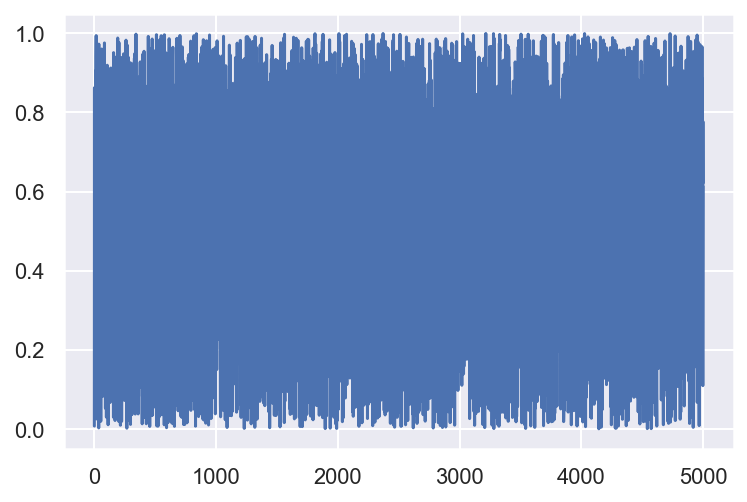

  0%|          | 0/100 [00:00<?, ?it/s]

In [115]:
epochs = 100
with LossTracker(epochs) as dp:
    
    for i in range(epochs):
        
        for j in range(50):
        
            dp.append(np.random.random())
        dp.update()

In [99]:
class Loss:
    @staticmethod
    def __call__(z_flow, theta_flow, n_sample, n_u, n_w, 
                 u, w, x, r, y):
        
        # Get unique users for this (mini)batch
        uniq_u = np.unique(u)
        uniq_w = np.unique(w)
        
        # Z: Sample base distribution and apply transformation
        z0_Z = z_flow.sample_base_dist(n_sample)
        zk_Z, base_dist_logprob_Z, log_det_Z = z_flow(z0_Z)
        
        # θ: Sample base distribution and apply transformation
        z0_θ = theta_flow.sample_base_dist(n_sample)
        zk_θ, base_dist_logprob_θ, log_det_θ = theta_flow(z0_θ)
        
        # Compute mean of log probability of base distribution samples
        ln_q0_Z = base_dist_logprob_Z.mean()
        ln_q0_θ = base_dist_logprob_θ.mean()
        
        # Compute mean of log determinants
        sum_ld_Z = log_det_Z.mean()
        sum_ld_θ = log_det_θ.mean()
        
        # Get Z-values used for first parameter
        Zu1 = zk_Z[:, :n_u].T
        Zw1 = zk_Z[:, n_u:n_w + n_u].T

        # Get Z-values used for second first parameter
        Zu2 = zk_Z[:, n_w + n_u:n_w + n_u * 2].T
        Zw2 = zk_Z[:, n_w + n_u * 2:].T
        
        # Get θ-values for both parameters
        mu1, log_var_u1, log_var_w1 = zk_θ[:, :3].T
        mu2, log_var_u2, log_var_w2 = zk_θ[:, 3:].T
        
        # Compute Z-values for both parameters
        Z1 = Zu1[u] + Zw1[w]
        Z2 = Zu2[u] + Zw2[w]
        
        # Go to constrained space
        param1 = torch.exp(Z1)
        param2 = torch.sigmoid(Z2)
        
        # Compute log probability of recall
        log_p = -param1 * x * (1 - param2) ** r
        
        # Comp. likelihood of observations
        ll = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum(axis=0).mean()
        
        # Comp. likelihood Z-values given population parameterization for first parameter
        ll_Zu1 = dist.Normal(mu1, torch.exp(0.5 * log_var_u1)).log_prob(Zu1[uniq_u]).sum(axis=0).mean()
        ll_Zw1 = dist.Normal(mu1, torch.exp(0.5 * log_var_w1)).log_prob(Zw1[uniq_w]).sum(axis=0).mean()
        
        # Comp. likelihood Z-values given population parameterization for first parameter
        ll_Zu2 = dist.Normal(mu2, torch.exp(0.5 * log_var_u2)).log_prob(Zu2[uniq_u]).sum(axis=0).mean()
        ll_Zw2 = dist.Normal(mu2, torch.exp(0.5 * log_var_w2)).log_prob(Zw2[uniq_w]).sum(axis=0).mean()
        
        # Add all the loss terms
        to_min = ln_q0_Z + ln_q0_θ - sum_ld_Z - sum_ld_θ \
            - ll - ll_Zu1 - ll_Zu2 - ll_Zw1 - ll_Zw2
        return to_min

In [100]:
class TeachingDataset(Dataset):
    def __init__(self, u, w, x, r, y):
        super().__init__()
        self.x = torch.from_numpy(x.reshape(-1, 1))
        self.y = torch.from_numpy(y.reshape(-1, 1))
        self.r = torch.from_numpy(r.reshape(-1, 1))
        self.u = u
        self.w = w
        
        self.n_u = len(np.unique(u))
        self.n_w = len(np.unique(w))
    
    def __len__(self):
        return len(self.u)
        
    def __getitem__(self, idx):
        return {'x': self.x[idx], 
                'y': self.y[idx], 
                'r': self.r[idx], 
                'u': self.u[idx], 
                'w': self.w[idx]}
        
    

In [101]:
data_dict, truth = simulate()

In [102]:
training_data = TeachingDataset(**data_dict)

In [118]:
n_u = training_data.n_u
n_w = training_data.n_w
print("N user", n_u)
print("N item", n_w)

N user 20
N item 20


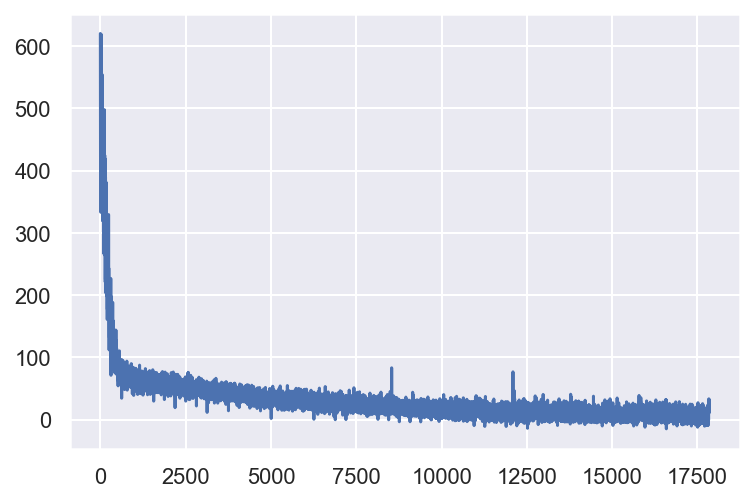

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
initial_lr = 0.001 # 0.005
flow_length = 16
n_epochs = 5000   # 100
n_sample = 40
batch_size= 128

freq_update_loss = 1 # for the progress bar


dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)


z_flow = NormalizingFlow(dim=(n_u + n_w) * 2, flow_length=flow_length)
theta_flow = NormalizingFlow(6, flow_length=flow_length)

optimizer = optim.Adam(
    list(z_flow.parameters()) + list(theta_flow.parameters()),
    lr=initial_lr)

loss_func = Loss()

# total_iterations = n_epochs*(len(training_data.u)//batch_size)
with LossTracker(n_epochs) as lt:

    for epoch in range(n_epochs):

        for d in dataloader:

            optimizer.zero_grad()
            loss = loss_func(z_flow=z_flow,
                             theta_flow=theta_flow,
                             n_sample=n_sample,
                             n_u=n_u, n_w=n_w,
                             **d)
            loss.backward()
            optimizer.step()

            # hist_loss.append(loss.item())
            lt.append(loss.item())
        
        lt.update()
#         if epoch % freq_update_loss == 0 and epoch > 0:
#             pbar.set_postfix(
#                 {'loss': np.mean(hist_loss[epoch - freq_update_loss:epoch])})
#         pbar.update()

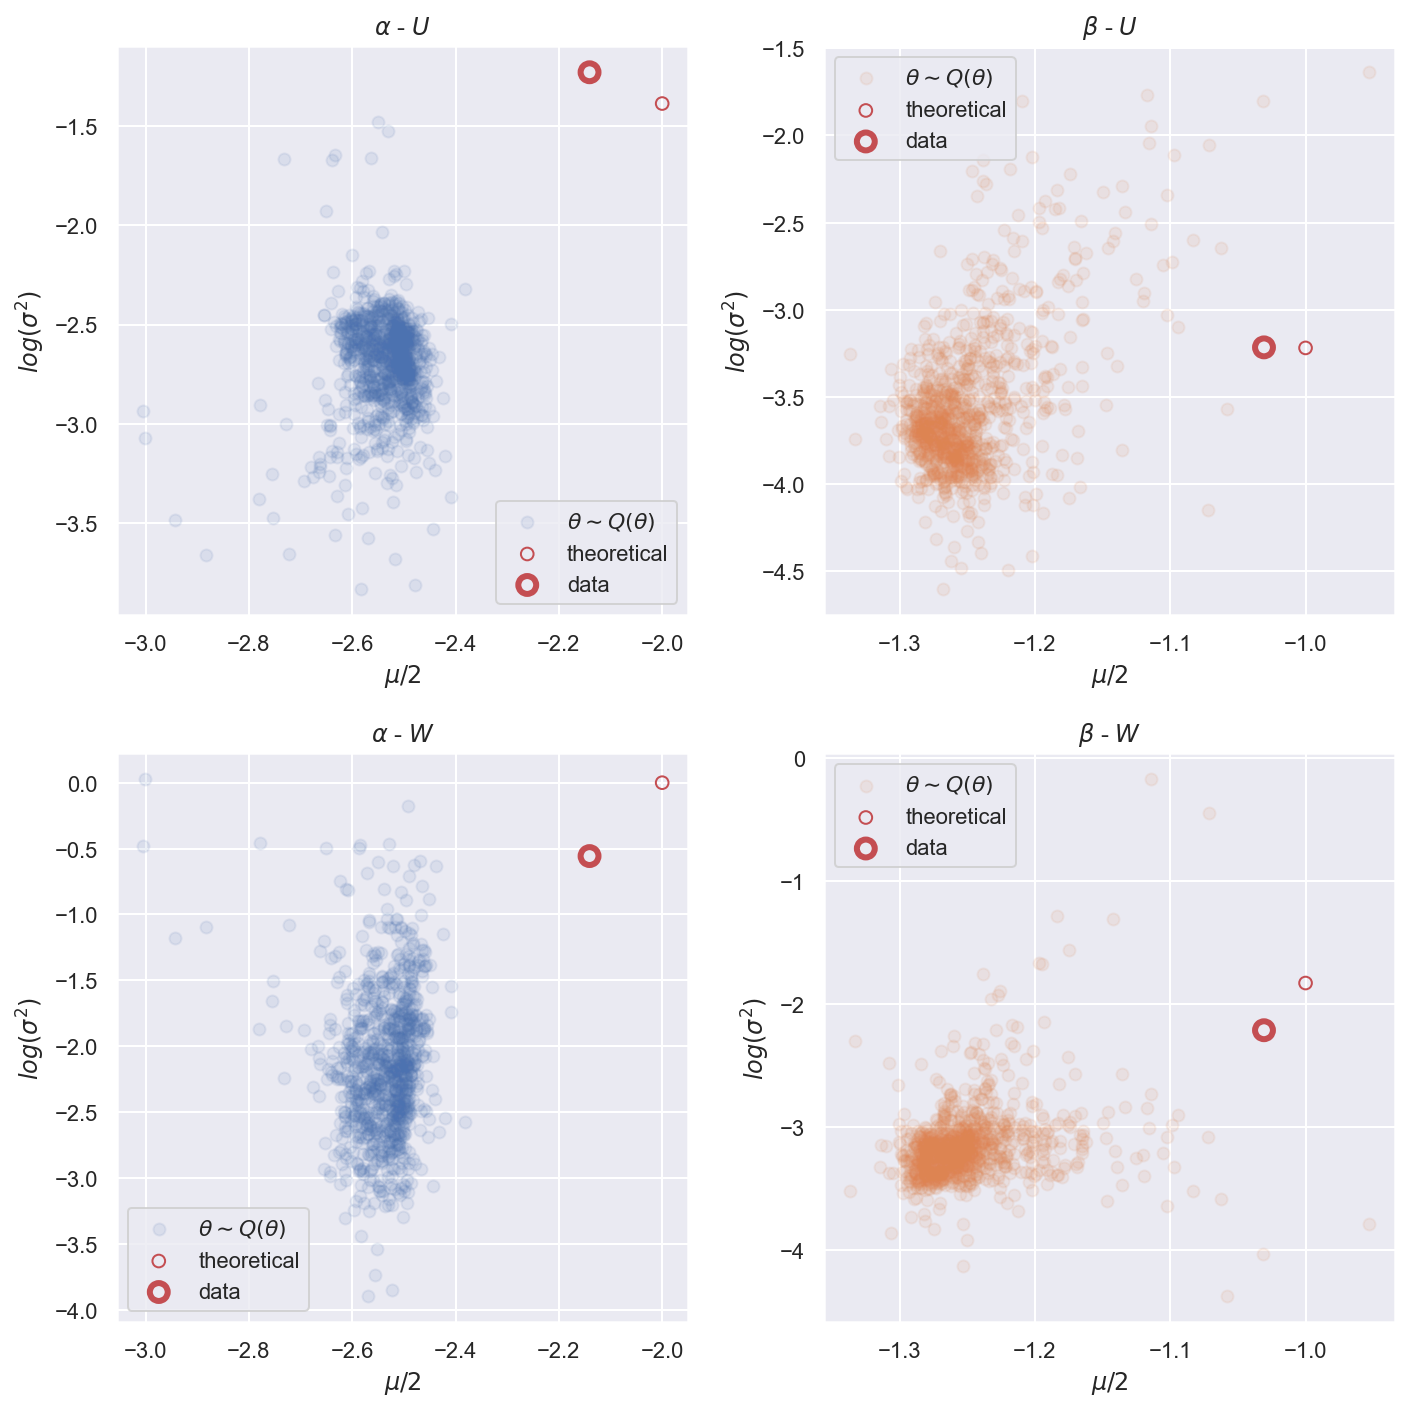

In [121]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name='artificial_mini_batch')

# Demo dynamic plot + progress bar

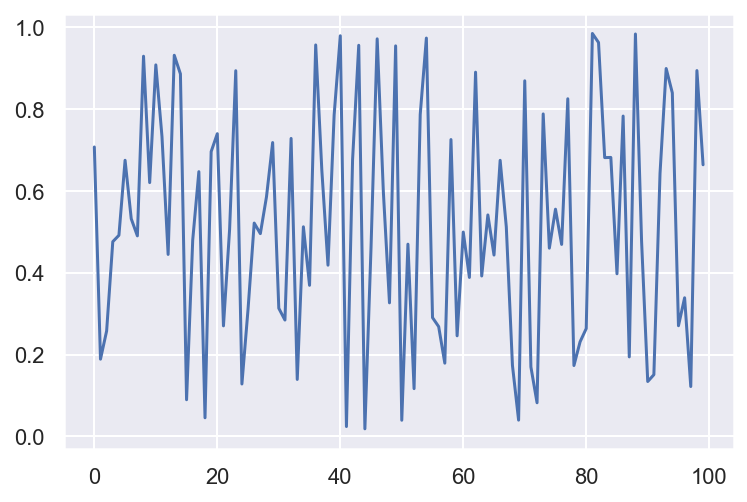

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
fig, ax =plt.subplots()
line, = ax.plot([], [])
hdisplay = display.display(None, display_id=True)

for i in tqdm(range(100)):
    
    new_x = i
    new_y = np.random.random()
    line.set_xdata(np.append(line.get_xdata(), new_x))
    line.set_ydata(np.append(line.get_ydata(), new_y))
    ax.relim()
    ax.autoscale_view()
    
    hdisplay.update(fig)
    sleep(0.2)

plt.close(fig)